In [1]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2 
import torchvision.transforms.functional as TF

import torch
import cv2
from torchvision.transforms import Compose
# from midas.transforms import Resize, NormalizeImage, PrepareForNet

In [20]:
LEARNING_RATE = 1e-4
SPLIT=0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {DEVICE}")

BATCH_SIZE = 4
EPOCHS = 1 #change to 10
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

device: cuda


## Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
input_folder_path = "/content/drive/MyDrive/Colab Notebooks/data/Project"

In [6]:
TRAIN_IMG_DIR = input_folder_path + '/train_2'
TRAIN_MASK_DIR = input_folder_path + '/mask_train_2'
VALID_IMG_DIR = input_folder_path + '/valid_2'
VALID_MASK_DIR = input_folder_path + '/mask_val_2'
TEST_IMG_DIR = input_folder_path + '/test_2'
TEST_MASK_DIR = input_folder_path + '/mask_test_2'

In [7]:
images_train = os.listdir(TRAIN_IMG_DIR)
masks_train = os.listdir(TRAIN_MASK_DIR)

images_val = os.listdir(VALID_IMG_DIR)
masks_val = os.listdir(VALID_MASK_DIR)

images_test = os.listdir(TEST_IMG_DIR)
masks_test = os.listdir(TEST_MASK_DIR)

### load image and concat the depth estimation

In [8]:
class IndoorDataset(Dataset):
    def __init__(self, images, image_dir, mask_dir, transform=None, train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.data_transform = transform
        self.isTrain = train
        self.images = images

        # Load the MiDaS model
        self.midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.midas.to(self.device)
        self.midas.eval()
        self.midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        self.transform = self.midas_transforms.dpt_transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        # Load the depth map with MiDaS
        depth_map = self.get_depth_map(image)

        # Apply transforms to the image, mask, and depth map
        if self.data_transform is not None:
            augmentations = self.data_transform(image=image, mask=mask)
            transformed_image = augmentations['image']
            mask = augmentations['mask']
            mask = np.floor(mask / 80)

            depth_transforms = A.Compose([
              A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
              A.Rotate(limit=35, p=1.0),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.1),
              ToTensorV2()
            ])

            depth_map = depth_transforms(image=depth_map)["image"]

        # Convert the transformed image and depth map to tensors
        image = transformed_image
        depth_map = depth_map.float()

        # Concatenate the depth map with the image along the channel dimension
        image = torch.cat([image, depth_map], dim=0)

        return image, mask

    def get_depth_map(self, img):
        # Process the image with the MiDaS model
        input_batch = self.transform(img).to(self.device)

        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="nearest-exact",
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        return depth_map

In [9]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [10]:
train_data = IndoorDataset(images_train,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = IndoorDataset(images_val,VALID_IMG_DIR,VALID_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:07<00:00, 178MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_

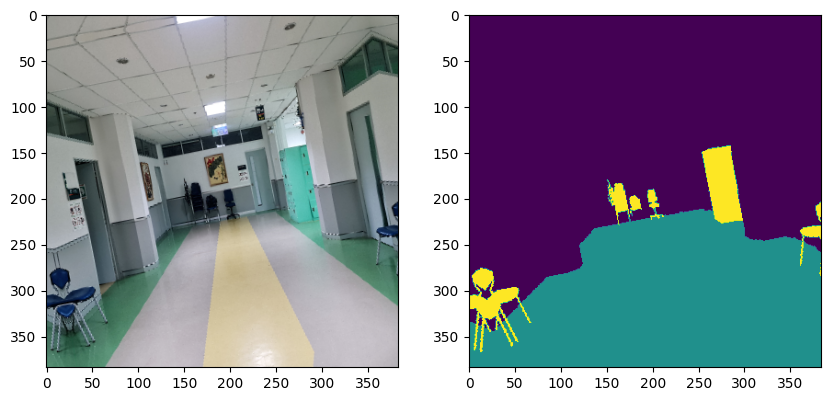

In [11]:
img, mask = train_data[0]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask)
plt.show()
plt.close('all')

##UNET Model

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.mpconv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=3, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
# Utility functions
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

In [14]:
model = UNet(4,3)
model = model.to(DEVICE)

In [15]:
if os.path.isfile(input_folder_path+"/my_checkpoint.pth.tar"):
    load_checkpoint(torch.load(input_folder_path+"/my_checkpoint.pth.tar"),model)    

=> Loading checkpoint


## Train and test on vallidation set

In [16]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    model.train()
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [17]:
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
check_accuracy(valid_dataloader, model, device=DEVICE)

Got 730637/884736 with acc 82.58


100%|██████████| 8/8 [00:55<00:00,  6.93s/it, loss=0.605]


=> Saving checkpoint
Got 738368/884736 with acc 83.46


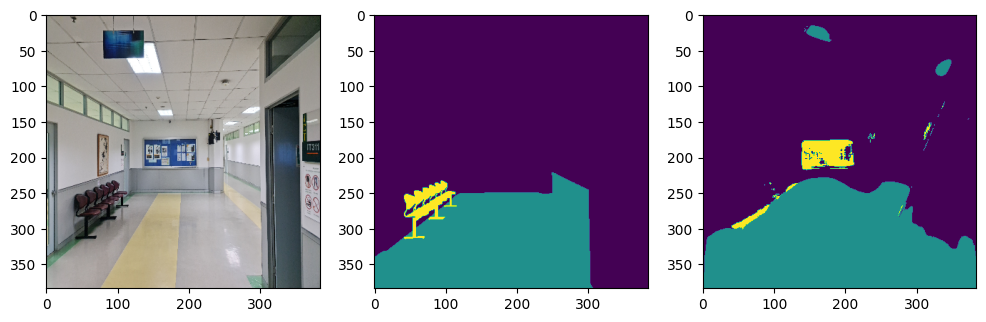

In [21]:
# Load the pre-trained model (if any)
if os.path.isfile("my_checkpoint.pth.tar"):
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Start training
for epoch in range(EPOCHS):
    train_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(valid_dataloader, model, device=DEVICE)

    # test on validation set
    model.eval()
    imgs, masks = next(iter(valid_dataloader))
    imgs = imgs.to(device=DEVICE)
    logits = model(imgs)
    pred_masks = torch.argmax(logits, dim=1)
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(imgs[i].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(masks[i].cpu().numpy())
    axs[2].imshow(pred_masks[i].cpu().numpy())
    plt.show()
    plt.close('all')

## Test set

In [22]:
test_data = IndoorDataset(images_test,TEST_IMG_DIR,TEST_MASK_DIR,validation_transform,True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [23]:
check_accuracy(test_dataloader, model, device=DEVICE)

Got 618336/884736 with acc 69.89


## Test on video

In [24]:
!python -m pip install pyyaml==5.1

!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=b36aaa3f598261585a696d9e460a9085fa15e8b8a97fdb3ffe7ec5772cdcbd5f
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [25]:
import os
import shutil
import numpy as np
import cv2
import torch
import ffmpeg
from tqdm import tqdm

### load video file

In [26]:
if os.path.isfile(input_folder_path+"/vdo_2.mp4"):
    print('found')

found


In [27]:
vidcap = cv2.VideoCapture(os.path.join(input_folder_path+'/vdo_2.mp4'))
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
target_img_w = 720
target_img_h = 480

### load midas for depth estimation

In [28]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.to(DEVICE)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [29]:
def get_depth_map(img, midas, transform, device):
    # Process the image with the MiDaS model
    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="nearest-exact",
        ).squeeze()
    depth_map = prediction.cpu().numpy()

    return depth_map

### test and create sequence of segmentation mask as output

In [30]:
# Output Stream
out_stream = (
    ffmpeg
    .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(target_img_w, target_img_h))
    .output('output2.mp4', pix_fmt='rgb24')
    .overwrite_output()
    .run_async(pipe_stdin=True)
)

success, image = vidcap.read()
with tqdm(total=frame_count, position=0, leave=True) as pbar:
    predictions = []
    while success:
        image = cv2.resize(
            image, (target_img_w, target_img_h), 
            interpolation=cv2.INTER_LINEAR)
        
        # Generate the depth map using the MiDaS model
        depth_map = get_depth_map(image, midas, transform, DEVICE)
        
        # Convert the image and depth map to a PyTorch tensor and normalize them
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
        depth_map_tensor = torch.tensor(depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        image_tensor = torch.cat([image_tensor, depth_map_tensor], dim=1)
        image_tensor = image_tensor.to(DEVICE)

        # Use your U-Net model for segmentation
        logits = model(image_tensor)
        pred_masks = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
        
        # Visualize the segmentation results (modify the visualization code to work with the U-Net output)
        out_image = np.zeros_like(image)
        for i in range(0, 3):  
            masks = pred_masks == i
            if i == 0:
                color = [61, 11, 81]  
            elif i == 1:
                color = [69, 142, 139] 
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = "Detected"
                position = (50, 50)
                font_scale = 1
                font_color = (255, 255, 255)
                line_type = 2
                cv2.putText(out_image, text, position, font, font_scale, font_color, line_type) 
            else:
                color = [250, 230, 85] 

            out_image[masks] = color  # Set the color for the current class
        
        out_stream.stdin.write(
            out_image
            .astype(np.uint8)
            .tobytes()
        )
        pbar.update()
        success, image = vidcap.read()
        predictions.append(pred_masks)

out_stream.stdin.close()


100%|██████████| 653/653 [04:26<00:00,  2.45it/s]
